In [46]:
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
[x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']


['device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0',
 'device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1c:00.0, compute capability: 7.0',
 'device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1d:00.0, compute capability: 7.0',
 'device: 3, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1e:00.0, compute capability: 7.0']

## Препроцессинг

In [47]:
from glob import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [255]:
diseases = []
images = []
cultures = []
for culture in glob("dataset/*"):
    for disease in glob(culture+"/*"):
        for s in glob(disease+"/*"):
            img = img_to_array(load_img(s, target_size=(224,224))) 
            diseases.append(disease.split('/')[-1])
            images.append(img)
            cultures.append(culture.split('/')[-1])
len(diseases), len(images)

(934, 934)

In [256]:
diseases[0], cultures[0]

('Anthracnose', 'Cucumbers')

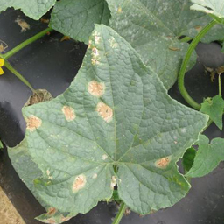

In [257]:
array_to_img(images[0])

In [258]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

de = LabelEncoder()
n_labels = de.fit_transform(diseases)
D = to_categorical(n_labels)

ce = LabelEncoder()
n_cultures = ce.fit_transform(cultures)
C = to_categorical(n_cultures)

In [259]:
labels_count = np.unique(n_labels).size
labels_count, np.unique(n_cultures).size

(16, 5)

In [260]:
D, C

(array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]], dtype=float32))

In [261]:
from tensorflow.keras.applications.nasnet import preprocess_input
X = preprocess_input(np.array(images))

In [262]:
from sklearn.model_selection import train_test_split
X_train, X_test, C_train, C_test, D_train, D_test = train_test_split(X, C, D, train_size=0.9, test_size=0.1, random_state=777) # поменял на исходные изображения

## Обучение

In [270]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D
import tensorflow as tf

In [290]:
restnet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3)) # загружаем предобученную сеть

output = restnet.layers[-1].output # используем выход пердыдущего слоя
restnet_output = Model(restnet.input, outputs=[output]) # создаем это все дело как модель
for layer in restnet.layers: # замораживаем предобученные слои модели
    layer.trainable = False


In [341]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Input, concatenate 
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

C_input = Input(shape=(C.shape[1]))

conv = Conv2D(600, (5,5))(restnet_output.output)
res_pooling = MaxPooling2D((3,3))(conv)
flat = Flatten()(res_pooling)

concat_l = concatenate([C_input, flat])

dense_1 = Dense(128, activation='sigmoid', input_dim=head_input_shape)(concat_l)
drop_1 = Dropout(0.3)(dense_1)
dense_3 = Dense(labels_count, activation='sigmoid')(drop_1)

model = Model(inputs=[restnet_output.input, C_input], outputs=[dense_3])
model.compile(loss='categorical_crossentropy', # лейблы кодируются в one-hot
                  optimizer=optimizers.RMSprop(lr=2e-5), # sgd с тюнингом
                  metrics=['accuracy'])
model.summary()

Model: "model_44"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_51[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
___________________________________________________________________________________________

In [342]:
model.input

[<tf.Tensor 'input_51:0' shape=(None, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'input_66:0' shape=(None, 5) dtype=float32>]

In [343]:
X_train.shape

(840, 224, 224, 3)

In [344]:
import datetime
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint.ch",
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit([X_train, C_train], D_train,
                    epochs=25,
                    validation_data=([X_test, C_test], D_test),
                    verbose=1)

Epoch 1/25
27/27 [==============================] - 1s 55ms/step - loss: 2.4420 - accuracy: 0.2714 - val_loss: 2.2588 - val_accuracy: 0.3830
Epoch 2/25
27/27 [==============================] - 1s 32ms/step - loss: 2.1106 - accuracy: 0.4810 - val_loss: 2.1428 - val_accuracy: 0.4574
Epoch 3/25
27/27 [==============================] - 1s 32ms/step - loss: 1.9835 - accuracy: 0.6357 - val_loss: 2.0597 - val_accuracy: 0.5745
Epoch 4/25
27/27 [==============================] - 1s 33ms/step - loss: 1.8681 - accuracy: 0.7702 - val_loss: 1.9949 - val_accuracy: 0.5957
Epoch 5/25
27/27 [==============================] - 1s 32ms/step - loss: 1.7843 - accuracy: 0.8393 - val_loss: 1.9455 - val_accuracy: 0.6489
Epoch 6/25
27/27 [==============================] - 1s 32ms/step - loss: 1.7250 - accuracy: 0.8607 - val_loss: 1.9569 - val_accuracy: 0.6383
Epoch 7/25
27/27 [==============================] - 1s 33ms/step - loss: 1.6767 - accuracy: 0.9167 - val_loss: 1.8960 - val_accuracy: 0.6702
Epoch 8/25
27

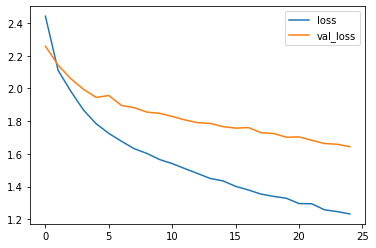

In [345]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss","val_loss"])

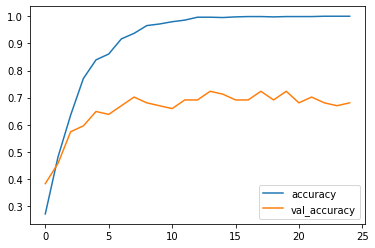

In [346]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["accuracy","val_accuracy"])